Welcome to my notebook! This is a copy/paste welcome message for all my notebooks :) 📓 This repository/notebook serves as a personal reminder for me, documenting code snippets and techniques sourced from various learning resources. The goal is to consolidate valuable information and create a basic reference guide. Please note that the codes included here are not originally mine, and credit goes to the respective authors and resources. Feel free to explore and use this collection as a shared learning space. Happy coding

#### Sources for this notebook : 
    * https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/tree/master/Chapter04
    * FMNIST Dataset
    * X-O dataset
    
#### Purpose :
    * Building CNN by Pytorch
    
#### Keywords :
    * FMNIST Dataset
    * CNN
    * Classification images
    * Image Augmentation
    * Visualize Filters

## Issues with image translation

In [1]:
from torchvision import datasets
import torch
data_folder = './data_FMNIST/FMNIST' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [4]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [5]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [6]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [7]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


Text(0.5, 1.0, 'Trouser')

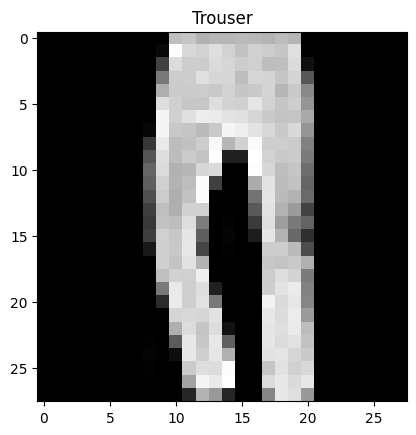

In [8]:
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

In [9]:
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

In [10]:
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([4.4780147e-05, 9.9994969e-01, 9.8139644e-08, 3.9659185e-06,
       9.1429897e-08, 3.4118323e-11, 1.4034808e-06, 2.9229921e-16,
       6.7347541e-09, 1.8526295e-13], dtype=float32)

##### index of 1 is the highest prob... prediction is correct!!

In [11]:
tr_targets[ix]

tensor(1)

##### apply tranlation and predict again

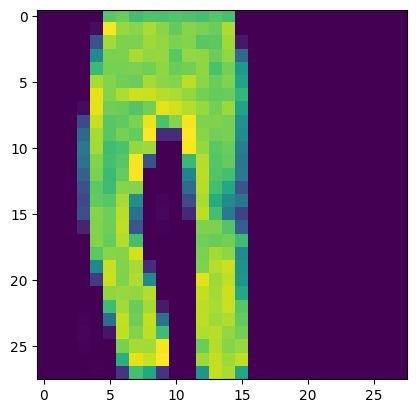

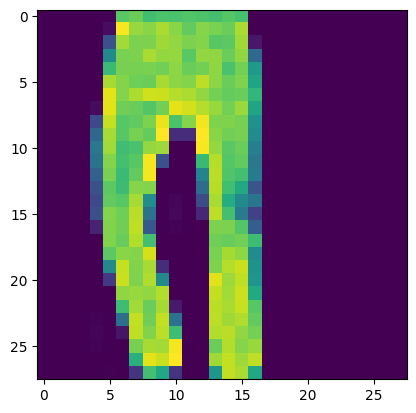

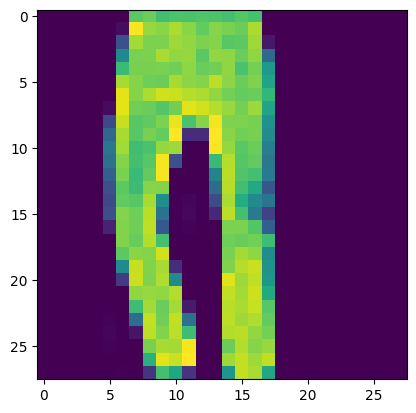

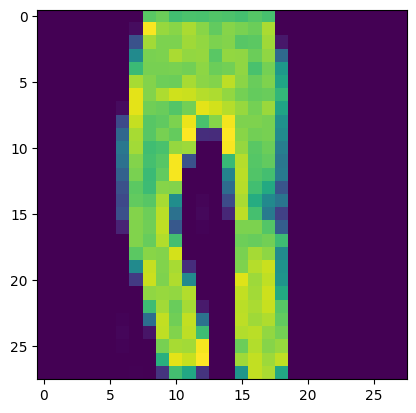

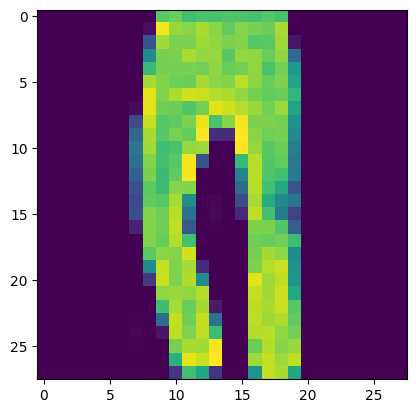

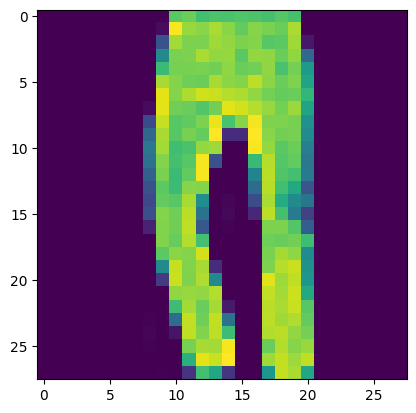

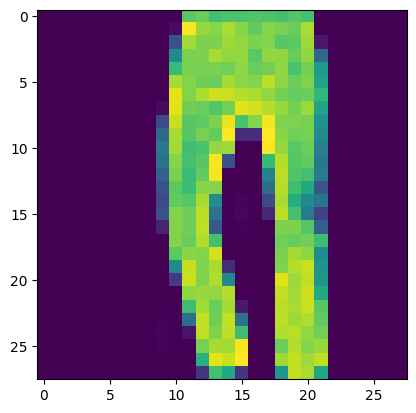

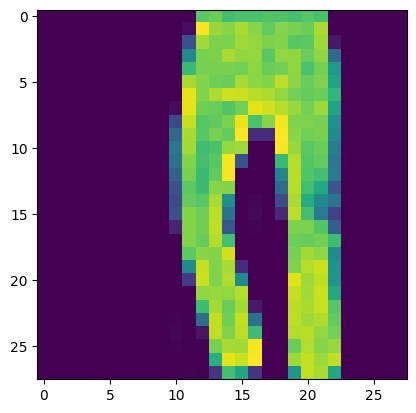

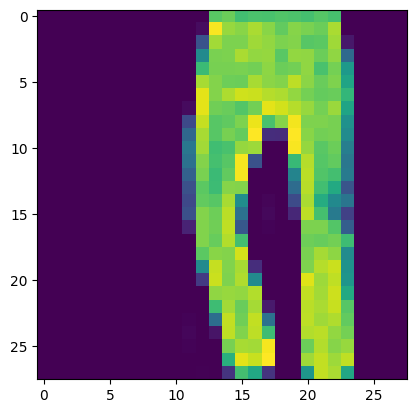

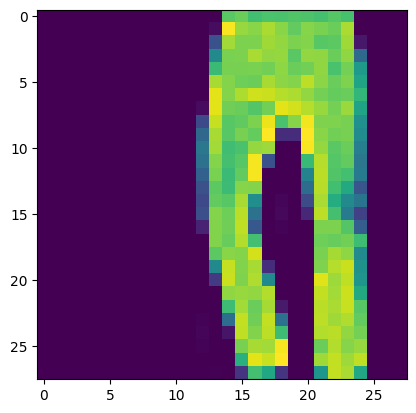

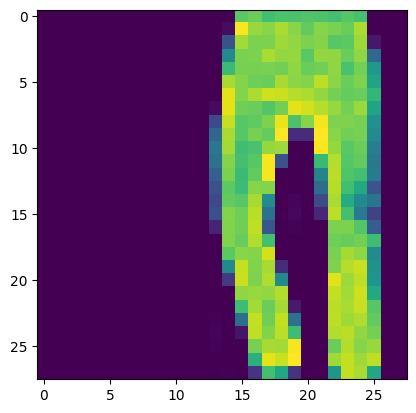

In [12]:
preds = []
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    #img2 = np.zeros((28,28))
    img2 = np.roll(img, px, axis=1)
    plt.imshow(img2)
    plt.show()
    img3 = torch.Tensor(img2).view(28*28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<Axes: title={'center': 'Probability of each class for various translations'}>

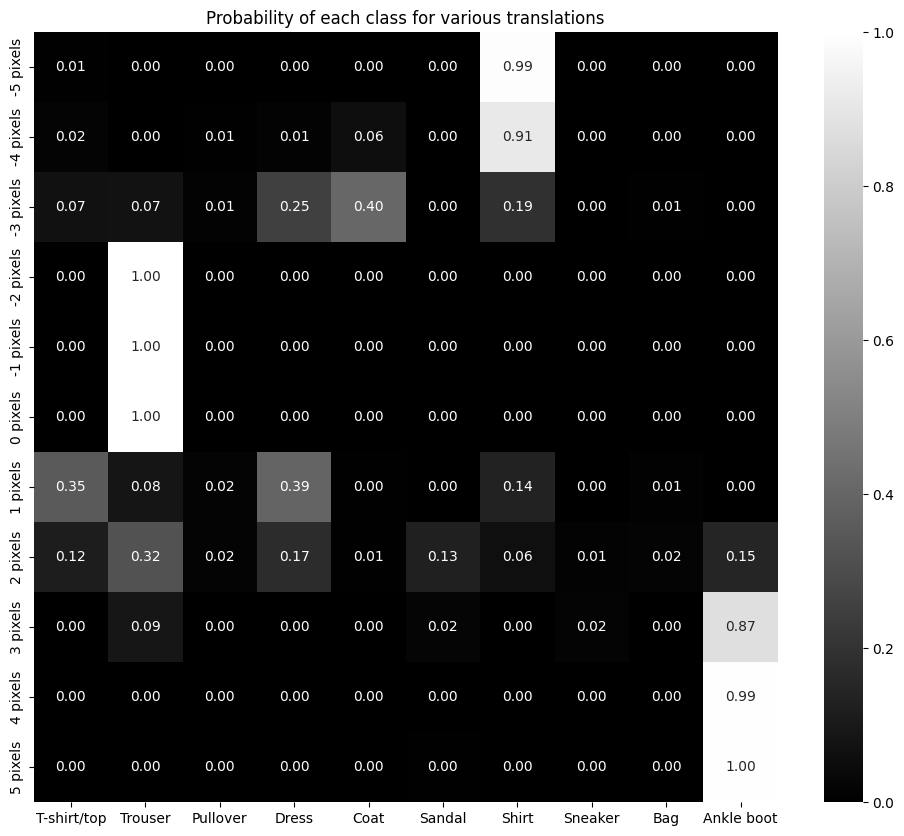

In [13]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

## Intro to CNN

In [14]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt


In [15]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],[5,6,7,8],[1,3,4,5]]],[[[-1,2,3,-4],[2,-3,4,5],[-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()
X_train /= 8
y_train = torch.tensor([0,1]).to(device).float()

In [16]:
X_train

tensor([[[[ 0.1250,  0.2500,  0.3750,  0.5000],
          [ 0.2500,  0.3750,  0.5000,  0.6250],
          [ 0.6250,  0.7500,  0.8750,  1.0000],
          [ 0.1250,  0.3750,  0.5000,  0.6250]]],


        [[[-0.1250,  0.2500,  0.3750, -0.5000],
          [ 0.2500, -0.3750,  0.5000,  0.6250],
          [-0.6250,  0.7500, -0.8750,  1.0000],
          [-0.1250, -0.3750, -0.5000, -0.6250]]]], device='cuda:0')

In [20]:
X_train.shape

torch.Size([2, 1, 4, 4])

In [17]:
y_train

tensor([0., 1.], device='cuda:0')

In [18]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [32]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model,(1,4,4));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 1, 2, 2]              10
         MaxPool2d-2              [-1, 1, 1, 1]               0
              ReLU-3              [-1, 1, 1, 1]               0
           Flatten-4                    [-1, 1]               0
            Linear-5                    [-1, 1]               2
           Sigmoid-6                    [-1, 1]               0
Total params: 12
Trainable params: 12
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [37]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    y = y.unsqueeze(1)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [34]:
trn_dl = DataLoader(TensorDataset(X_train, y_train))

In [35]:
len(trn_dl)

2

In [38]:
for epoch in range(2000):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

In [39]:
model(X_train[:1])

tensor([[5.3467e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Let's dive in and understand step by step 

In [40]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [41]:
# take weigths and biases.. if a layer has...
(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, layer.bias.data) for layer in list(model.children()) if hasattr(layer, 'weight')]

In [42]:
h_im, w_im = X_train.shape[2:]
h_conv, w_conv = cnn_w.shape[2:]
sumprod = torch.zeros((h_im - h_conv + 1, w_im - w_conv + 1))

In [44]:
h_im,w_im

(4, 4)

In [45]:
h_conv, w_conv

(3, 3)

In [46]:
sumprod

tensor([[0., 0.],
        [0., 0.]])

In [47]:
#apply conv operation with first input

for i in range(h_im - h_conv + 1):
    for j in range(w_im - w_conv + 1):
        img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
        model_filter = cnn_w.reshape(3,3)
        val = torch.sum(img_subset*model_filter) + cnn_b
        sumprod[i,j] = val

In [48]:
sumprod.clamp_min_(0)

tensor([[5.2090, 6.5707],
        [4.7782, 6.3233]])

In [49]:
pooling_layer_output = torch.max(sumprod)

In [50]:
pooling_layer_output

tensor(6.5707)

In [51]:
# linear activation
intermediate_output_value = pooling_layer_output * lin_w + lin_b

In [52]:
intermediate_output_value

tensor([[-9.8364]], device='cuda:0')

In [53]:
from torch.nn import functional as F # torch library for numpy like functions
print(F.sigmoid(intermediate_output_value))

tensor([[5.3467e-05]], device='cuda:0')


Same result with model output.

## CNN on FMNIST Dataset

In [54]:
from torchvision import datasets
import torch
data_folder = './data_FMNIST/FMNIST' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [57]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [58]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [59]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [60]:
trn_dl

In [62]:
for x,y in trn_dl:
    print(x.shape)
    print(y)
    break

torch.Size([32, 1, 28, 28])
tensor([8, 4, 5, 0, 3, 1, 4, 0, 8, 2, 1, 0, 0, 9, 0, 9, 5, 4, 2, 4, 0, 9, 0, 4,
        1, 1, 2, 4, 5, 0, 1, 7], device='cuda:0')


In [65]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model,(1,28,28));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [66]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


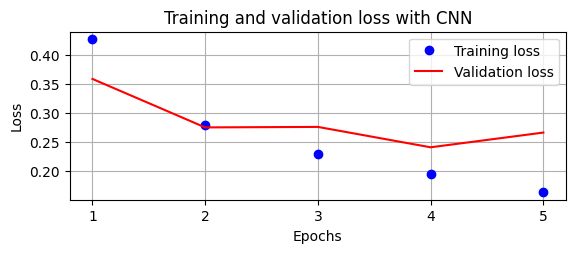

C:\Users\Zeki\AppData\Local\Temp\ipykernel_1892\3239377513.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


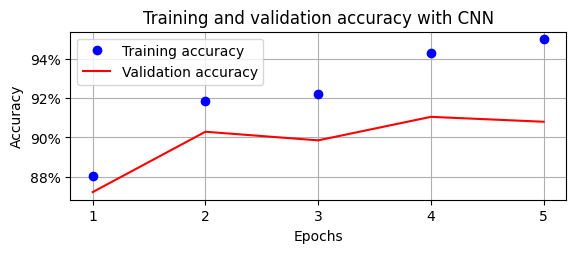

In [67]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

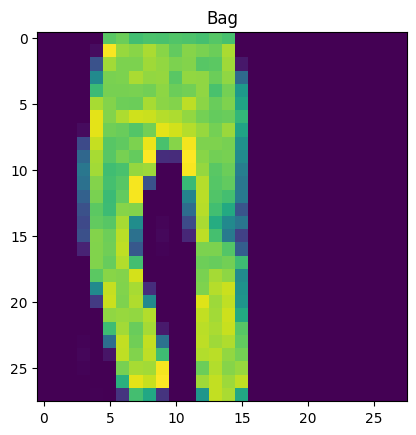

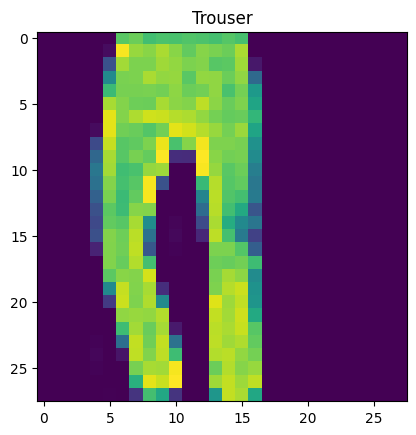

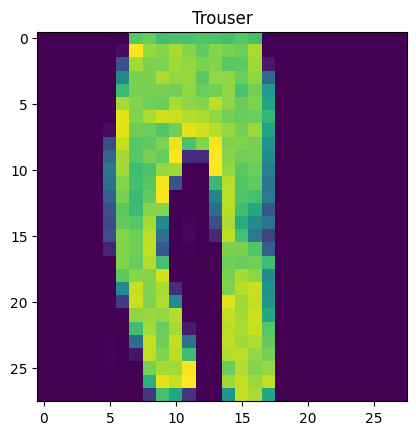

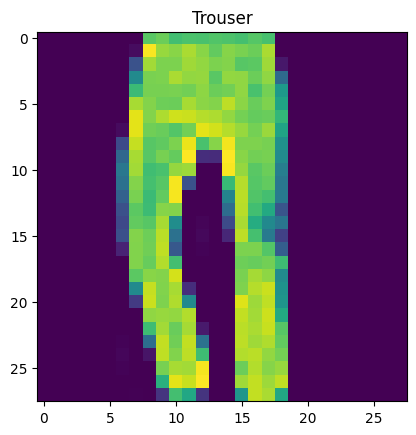

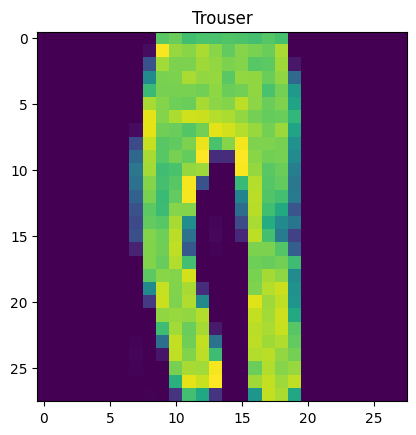

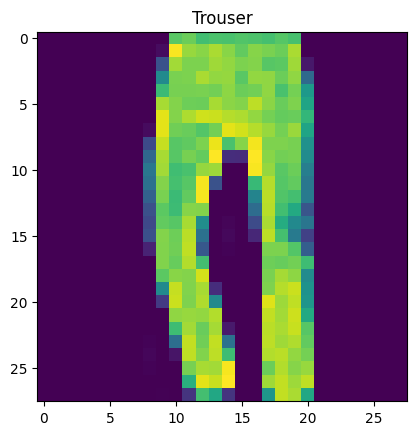

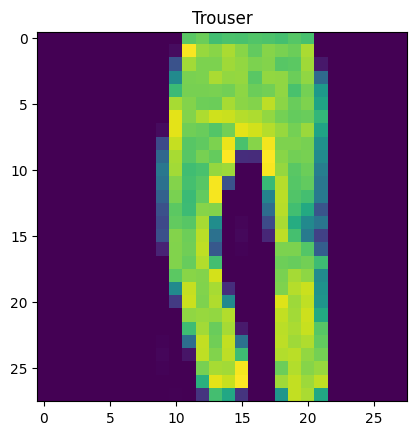

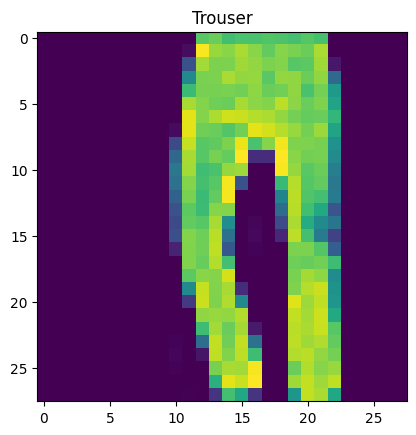

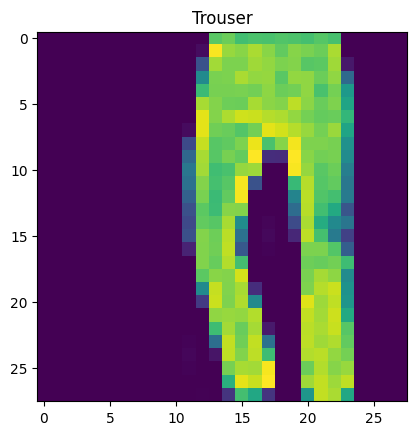

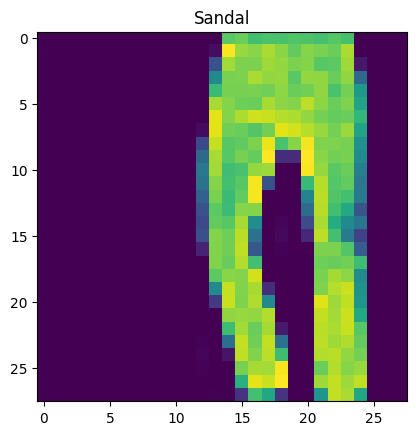

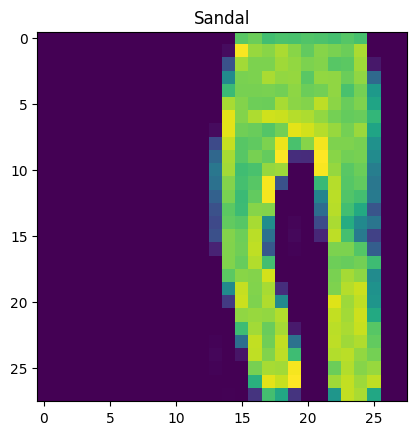

In [68]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

In [69]:
np.array(preds).shape

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

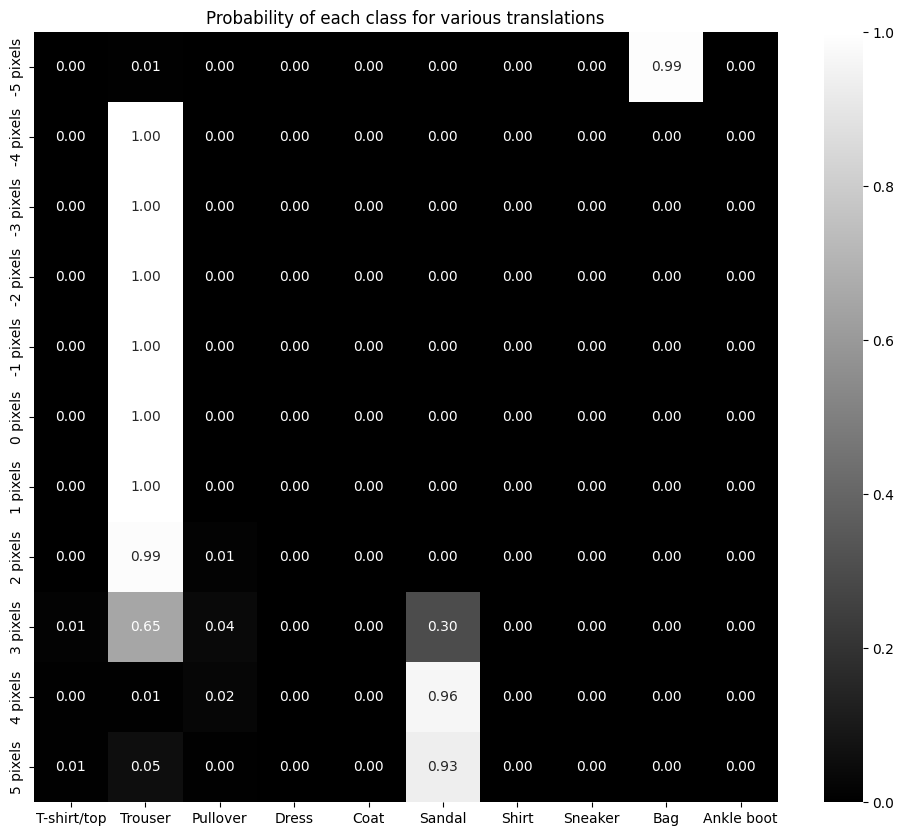

In [70]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

In [71]:
preds

[array([[1.4595326e-05, 7.1004899e-03, 2.8622273e-05, 8.8660012e-04,
         1.1507401e-05, 8.1470954e-09, 2.3187725e-04, 7.8935735e-13,
         9.9172628e-01, 1.3576640e-11]], dtype=float32),
 array([[3.6692177e-06, 9.9987835e-01, 4.2231086e-06, 2.3047530e-06,
         4.0263631e-06, 1.5411261e-07, 1.5503350e-06, 1.1775218e-12,
         1.0578124e-04, 6.9707437e-14]], dtype=float32),
 array([[6.0731210e-08, 9.9999648e-01, 1.1998770e-08, 3.6753529e-09,
         3.7205602e-08, 3.0162470e-10, 3.2752094e-08, 4.1347537e-12,
         3.3883227e-06, 3.9134087e-15]], dtype=float32),
 array([[7.9258317e-10, 1.0000000e+00, 2.3206391e-10, 1.7779781e-11,
         8.1245996e-13, 4.6061901e-13, 2.1834797e-12, 1.6350169e-14,
         6.8806398e-11, 1.3649570e-19]], dtype=float32),
 array([[9.0180599e-11, 1.0000000e+00, 1.0035355e-11, 1.3174208e-13,
         2.6566724e-14, 1.5388695e-16, 2.3540560e-14, 2.4600583e-18,
         3.4125310e-15, 3.6019657e-21]], dtype=float32),
 array([[2.4183016e-08, 1

## Image Augmentation

In [72]:
!pip install -U imgaug

     ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
     - ------------------------------------- 30.7/948.0 kB 1.3 MB/s eta 0:00:01
     --- ----------------------------------- 92.2/948.0 kB 1.1 MB/s eta 0:00:01
     ------ ------------------------------- 153.6/948.0 kB 1.3 MB/s eta 0:00:01
     ---------- --------------------------- 256.0/948.0 kB 1.6 MB/s eta 0:00:01
     ------------- ------------------------ 337.9/948.0 kB 1.6 MB/s eta 0:00:01
     ------------------ ------------------- 450.6/948.0 kB 1.7 MB/s eta 0:00:01
     -------------------------- ----------- 655.4/948.0 kB 2.1 MB/s eta 0:00:01
     --------------------------------- ---- 829.4/948.0 kB 2.4 MB/s eta 0:00:01
     -------------------------------------- 948.0/948.0 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/1.4 MB 5.1 MB/s eta 0:00:01
     --------- ------------------------------ 0.4/1.4 MB 4

In [73]:
import imgaug.augmenters as iaa

In [74]:
from torchvision import datasets
import torch
data_folder = './data_FMNIST/FMNIST' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [76]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

Text(0.5, 1.0, 'Original image')

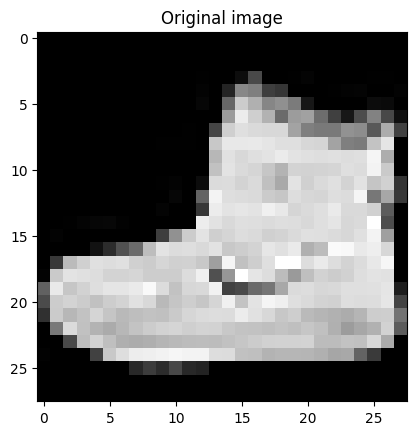

In [77]:
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')

Text(0.5, 1.0, 'Scaled image')

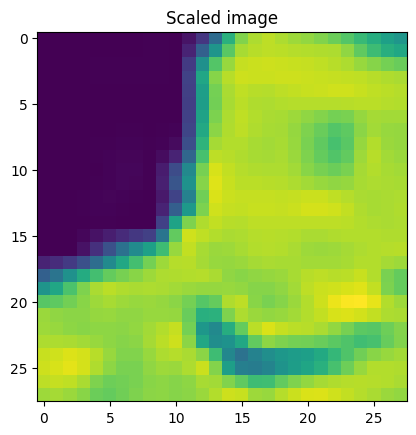

In [78]:
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')

Text(0.5, 1.0, 'Translated image by 10 pixels (right and bottom)')

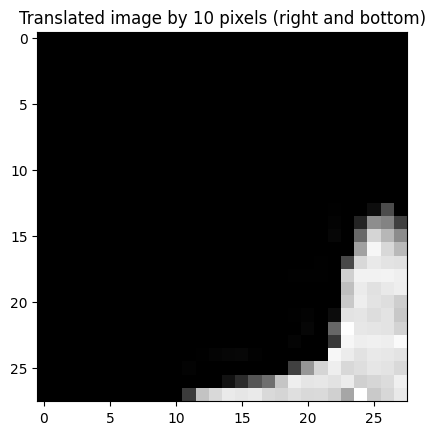

In [79]:
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translated image by 10 pixels (right and bottom)')

Text(0.5, 1.0, 'Translation of 10 pixels \nacross columns and 2 pixels over rows')

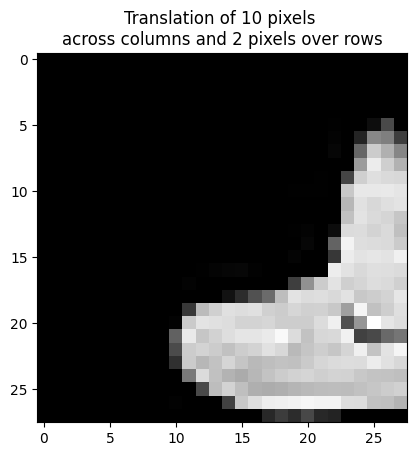

In [80]:
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels \nacross columns and 2 pixels over rows')

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

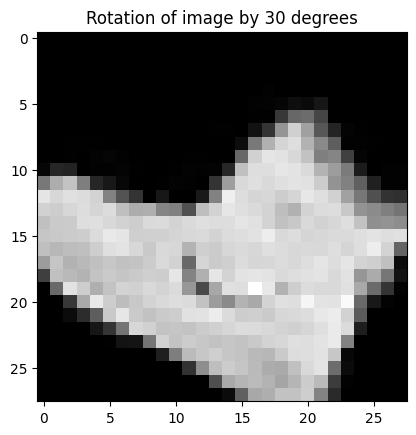

In [81]:
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by -30 degrees')

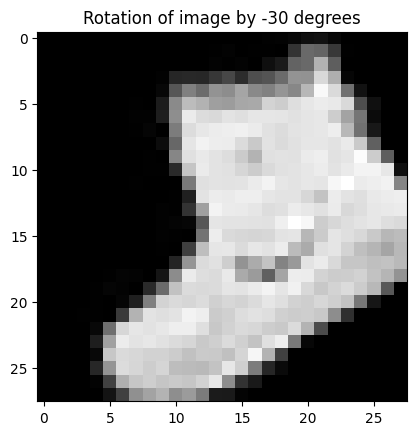

In [82]:
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by -30 degrees')

Text(0.5, 1.0, 'Shear of image by 30 degrees')

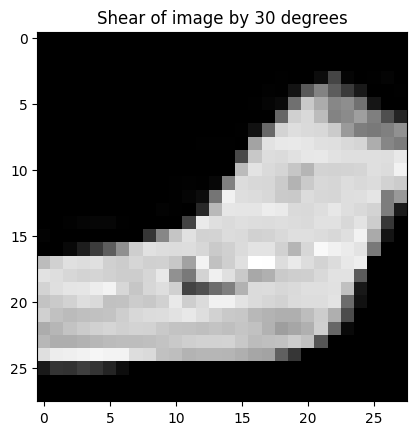

In [83]:
aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by 30 degrees')

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

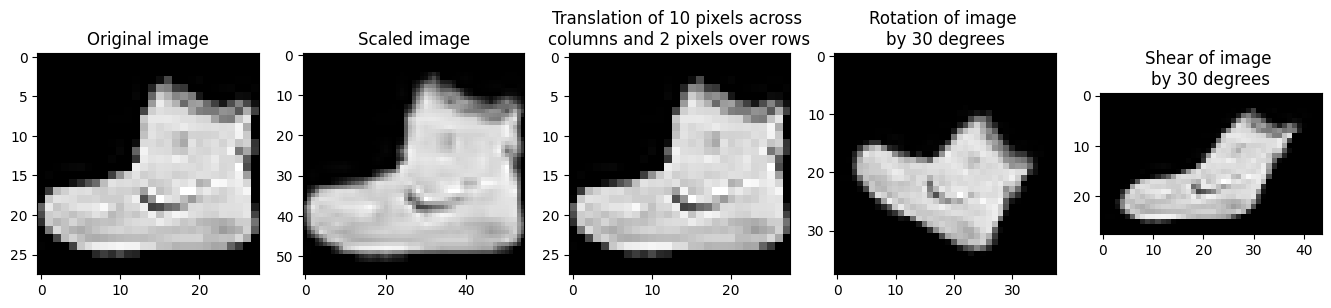

In [84]:
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

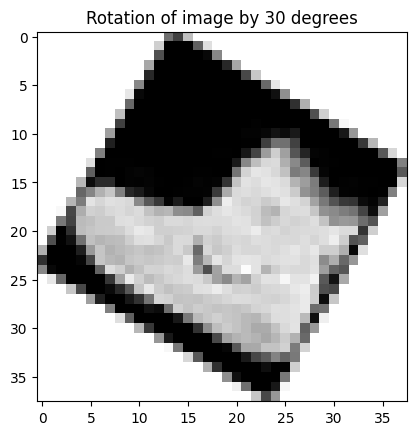

In [85]:
aug = iaa.Affine(rotate=30, fit_output=True, cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by \n30 degrees with wrap mode')

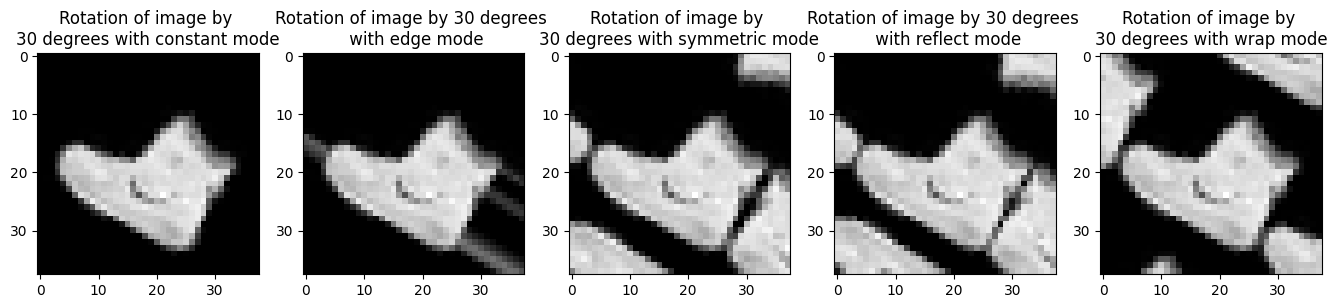

In [86]:
plt.figure(figsize=(20,20))
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with wrap mode')

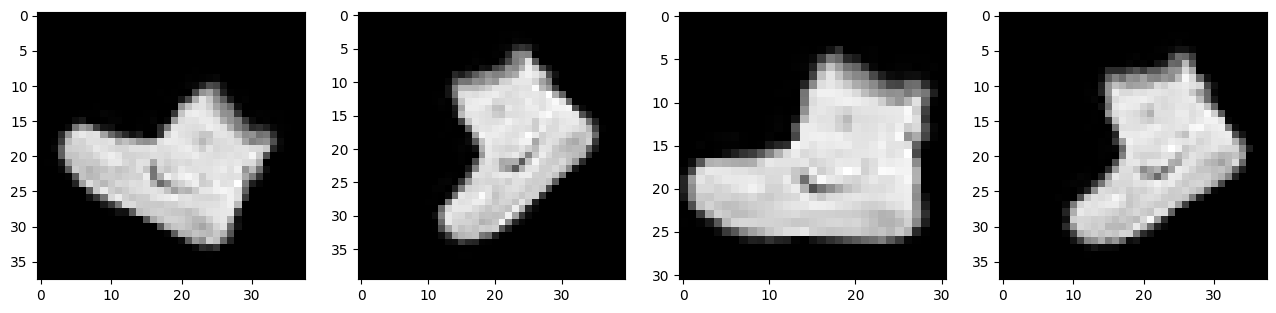

In [87]:
plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

Text(0.5, 1.0, 'Pixels multiplied by 0.5')

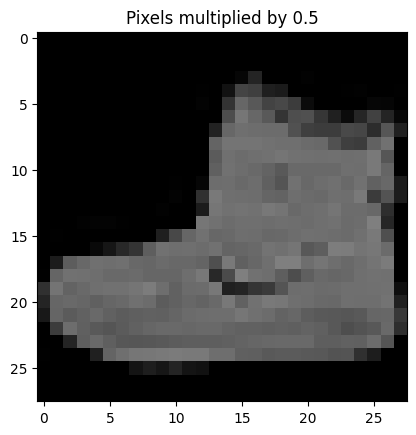

In [88]:
aug = iaa.Multiply(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Pixels multiplied by 0.5')

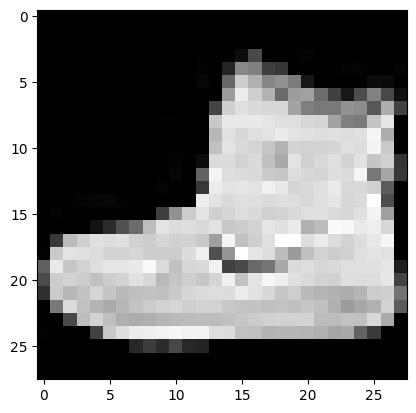

In [89]:
aug = iaa.Multiply(1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

Text(0.5, 1.0, 'Pixel contrast by 0.5')

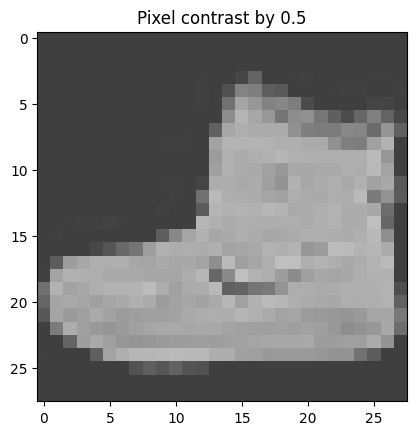

In [90]:
aug = iaa.LinearContrast(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Pixel contrast by 0.5')

Text(0.5, 1.0, 'Random 20% pixel dropout')

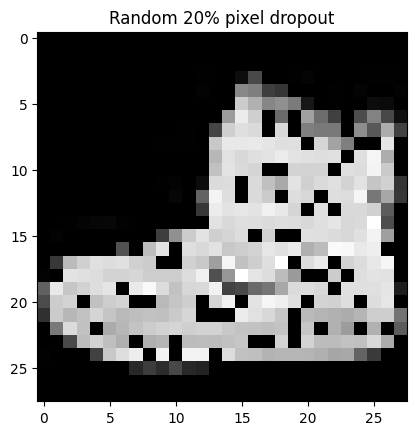

In [91]:
aug = iaa.Dropout(p=0.2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')

Text(0.5, 1.0, 'Random 20% salt and pepper noise')

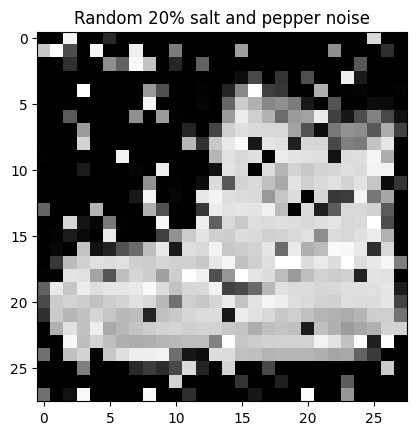

In [92]:
aug = iaa.SaltAndPepper(0.2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

Text(0.5, 1.0, 'Random 20% salt and pepper noise')

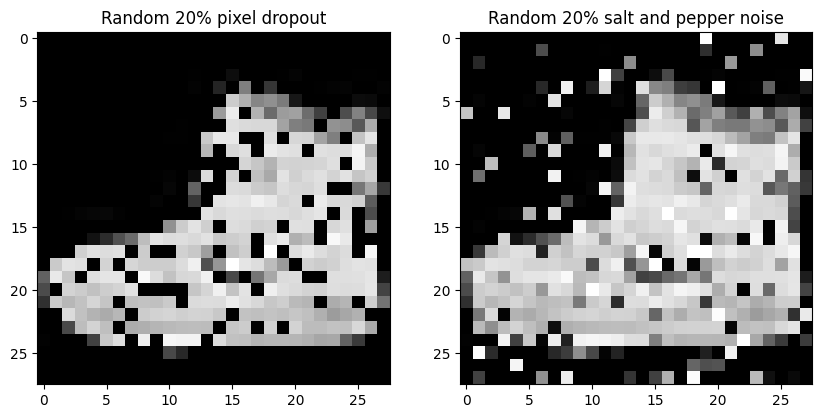

In [93]:
plt.figure(figsize=(10,10))
plt.subplot(121)
aug = iaa.Dropout(p=0.2,)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')
plt.subplot(122)
aug = iaa.SaltAndPepper(0.2,)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

Text(0.5, 1.0, 'Image augmented using a \nrandom orderof the two augmentations')

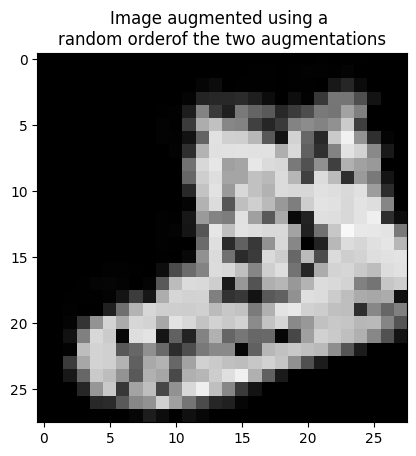

In [94]:
seq = iaa.Sequential([
      iaa.Dropout(p=0.2,),
    iaa.Affine(rotate=(-30,30))], random_order= True)

plt.imshow(seq.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Image augmented using a \nrandom orderof the two augmentations')

Text(0.5, 1.0, 'Gaussian blurring of image\n with a sigma of 1')

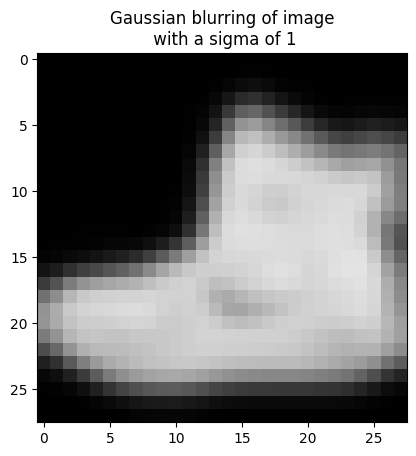

In [95]:
aug = iaa.GaussianBlur(sigma=1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Gaussian blurring of image\n with a sigma of 1')

## Time comparison of augmentation scenario

In [96]:
from torchvision import datasets
import torch
data_folder = './data_FMNIST/FMNIST' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [97]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([
              iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),
            ])

In [100]:
%%time
for i in range(32):
    aug.augment_image(to_numpy(tr_images[i]))

CPU times: total: 15.6 ms
Wall time: 24 ms


In [102]:
%%time
x = aug.augment_images(to_numpy(tr_images[:32]))

CPU times: total: 0 ns
Wall time: 13 ms


## Data Augmentation for image translation

In [103]:
from torchvision import datasets
import torch
data_folder = './data_FMNIST/FMNIST' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [105]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)},
        mode='constant'),
])

In [133]:
def to_numpy(x: torch.Tensor) -> np.ndarray:
    return x.cpu().detach().numpy()

class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self): return len(self.x)

    def collate_fn(
        self, batch: list[tuple[torch.Tensor, torch.Tensor]]
    ) -> tuple[torch.Tensor, torch.Tensor]:
        ims, classes = zip(*batch)
        ims = torch.stack(ims)
        if self.aug:
            ims = self.aug.augment_images(images=to_numpy(ims))
        ims = torch.tensor(ims)[:, None, :, :] / 255.0
        classes = torch.tensor(classes)
        return ims.to(device), classes.to(device)

In [134]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [135]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [136]:
 def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    'notice the collate_fn argument'
    trn_dl = DataLoader(train, batch_size=64,
                collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

In [137]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()


In [138]:
len(trn_dl)

938

In [139]:
for x,y in trn_dl:
    print(x.shape)
    print(y)
    break

torch.Size([64, 1, 28, 28])
tensor([5, 3, 9, 5, 8, 3, 9, 3, 5, 9, 5, 6, 0, 9, 2, 7, 6, 1, 2, 7, 9, 6, 2, 8,
        3, 6, 7, 2, 9, 0, 3, 1, 7, 7, 6, 0, 8, 2, 2, 8, 8, 4, 8, 2, 9, 4, 6, 7,
        7, 0, 8, 7, 6, 8, 5, 4, 8, 1, 1, 9, 9, 2, 2, 1], device='cuda:0')


In [141]:
for epoch in range(5):
    print(epoch)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

0
1
2
3
4


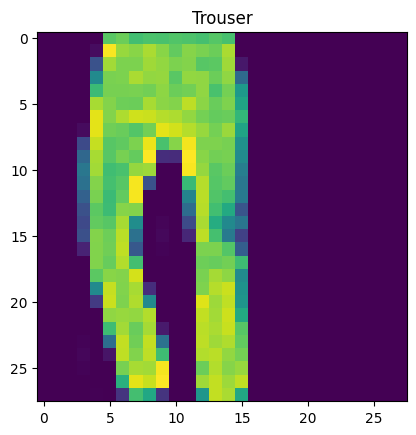

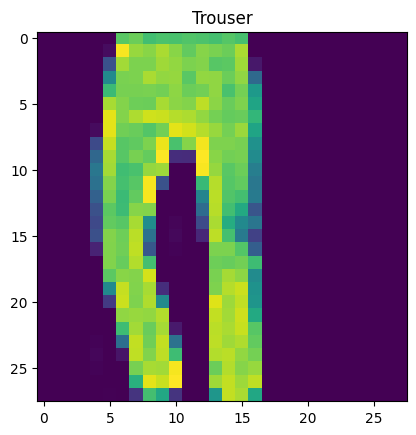

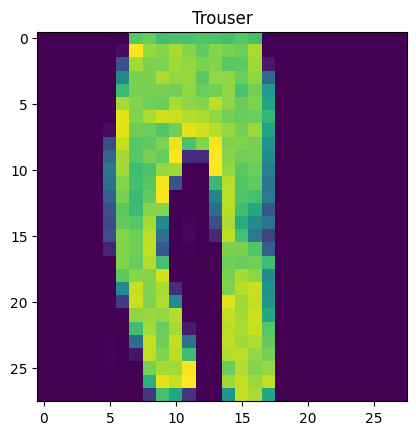

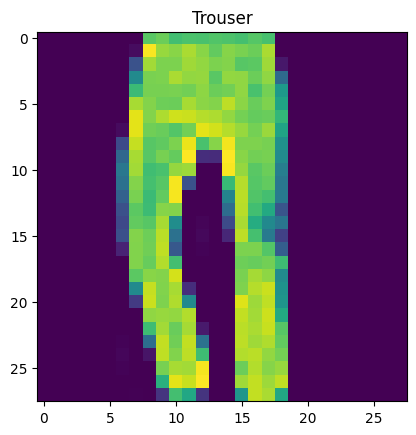

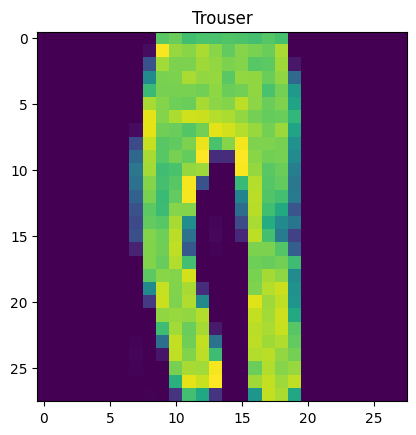

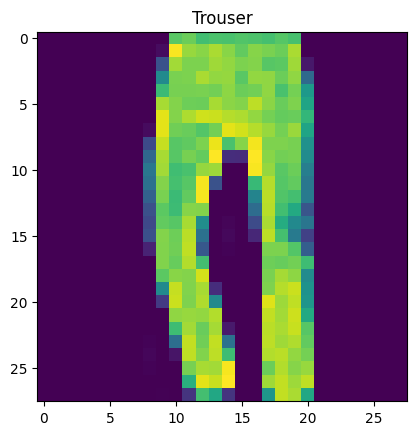

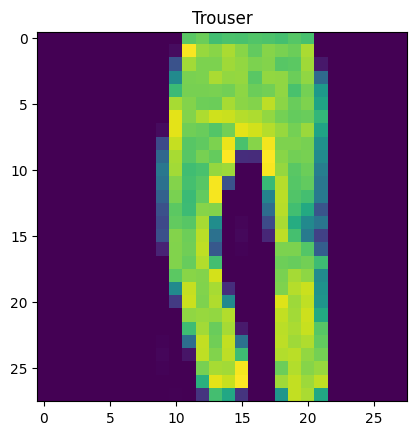

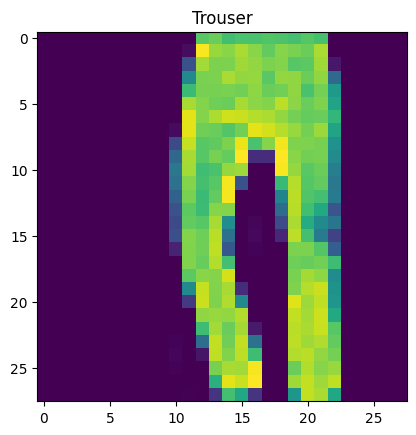

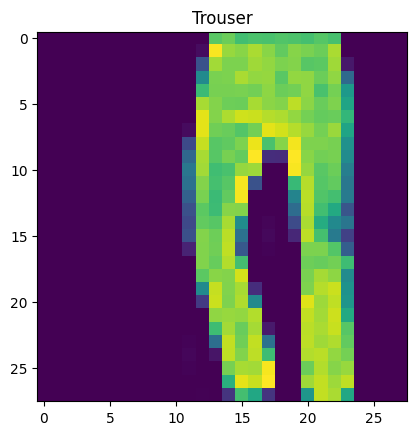

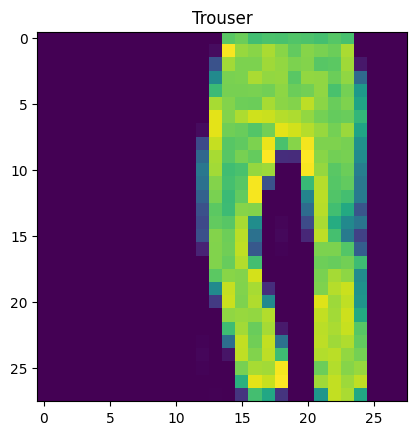

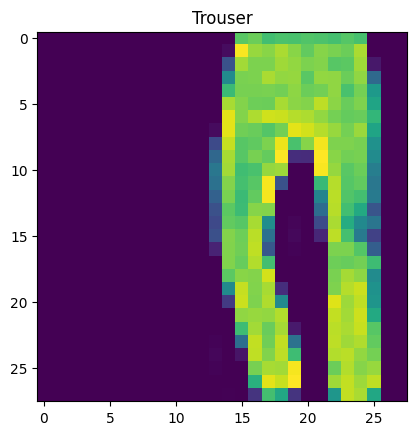

In [142]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

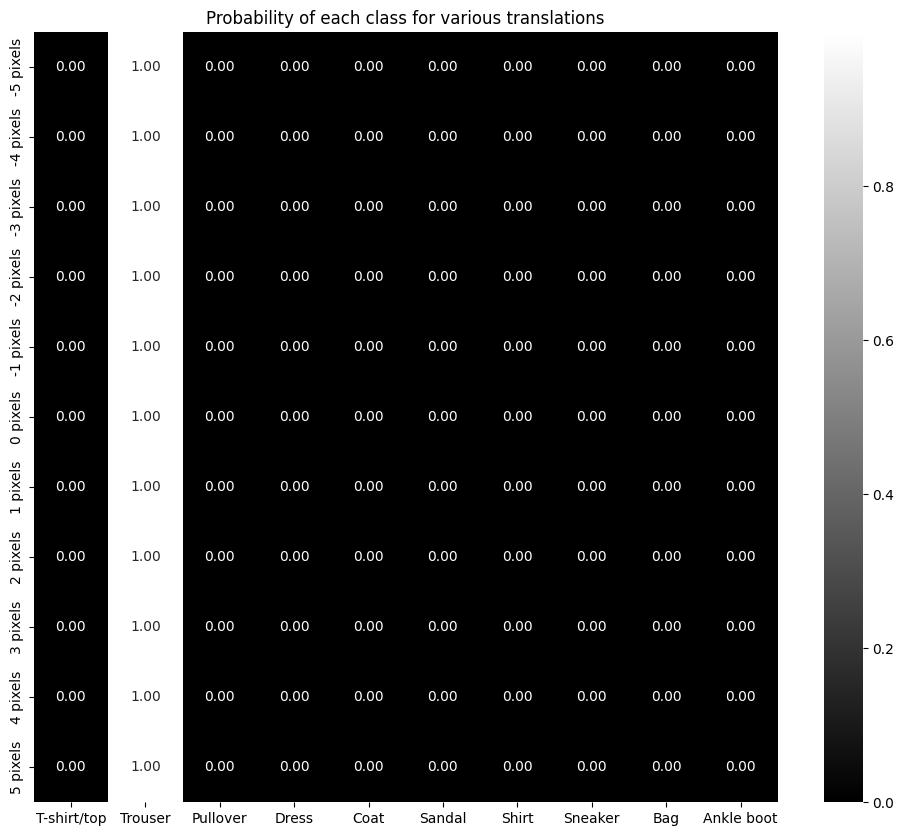

In [143]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

## Visualize filters

In [144]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
from imgaug import augmenters as iaa

In [145]:
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [146]:
data = XO('./all/*')

In [147]:
data

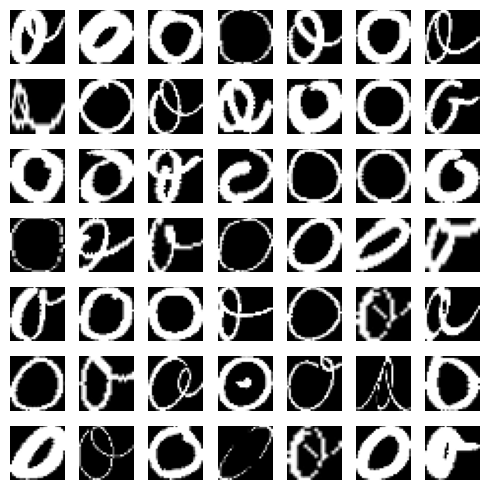

In [148]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [149]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [150]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [151]:
trn_dl = DataLoader(data, batch_size=32, drop_last=True)

In [152]:
trn_dl

In [153]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [154]:
model, loss_fn, optimizer = get_model()

In [155]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [156]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

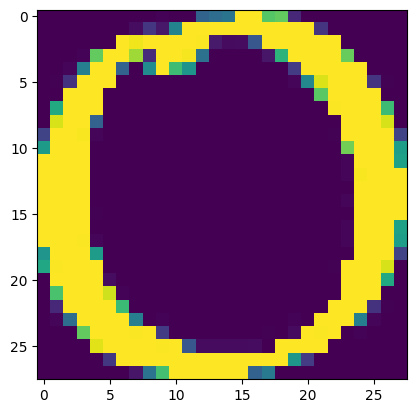

In [157]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

In [158]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

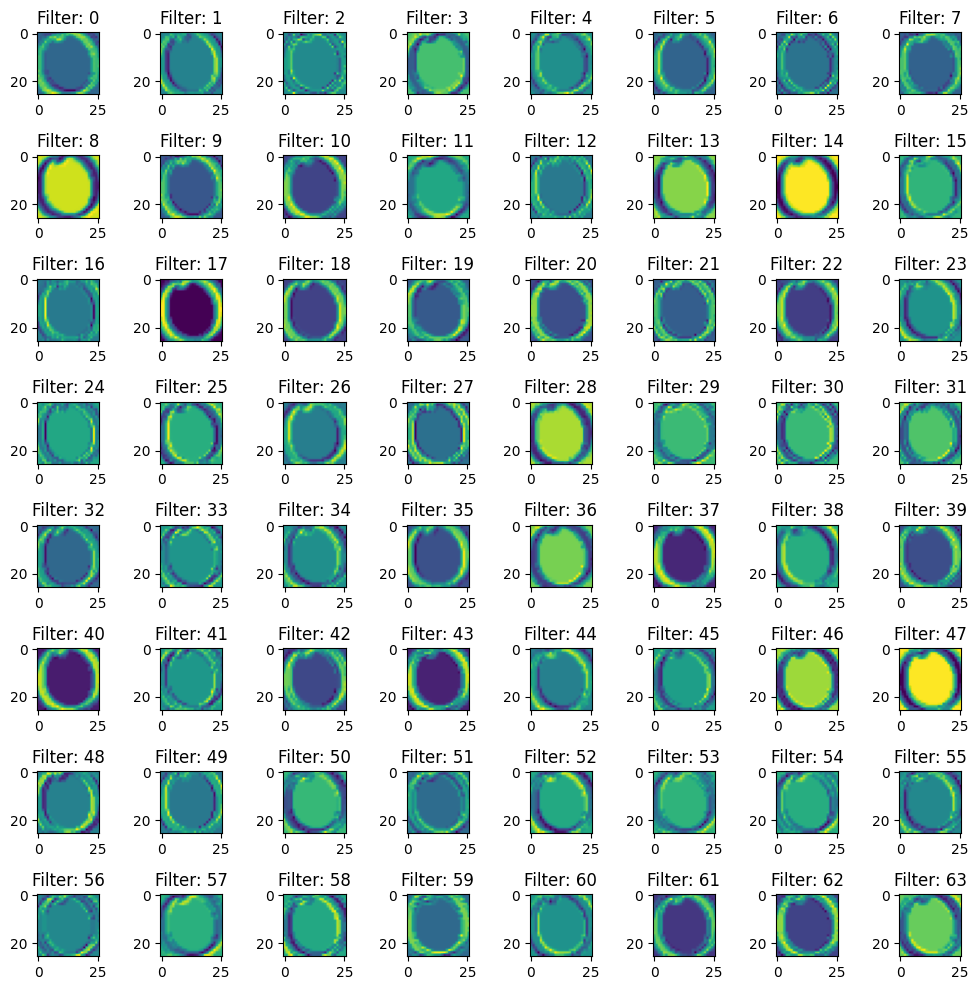

In [159]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [160]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [161]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

In [162]:
second_intermediate_output.shape

torch.Size([128, 11, 11])

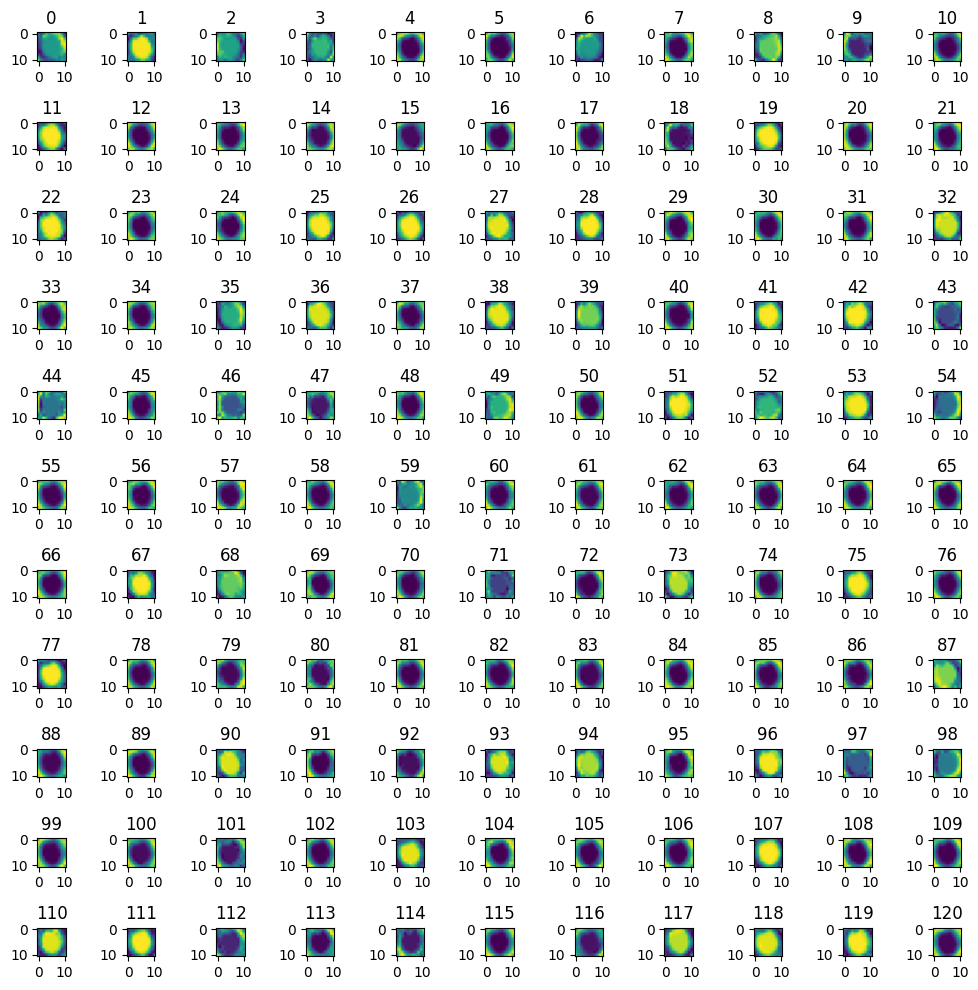

In [163]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [164]:
im.shape

torch.Size([1, 28, 28])

In [165]:
x, y = next(iter(trn_dl))
x2 = x[y==0]
len(x2)

32

In [166]:
x2 = x2.view(-1,1,28,28)

In [167]:
x2.shape

torch.Size([32, 1, 28, 28])

In [168]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

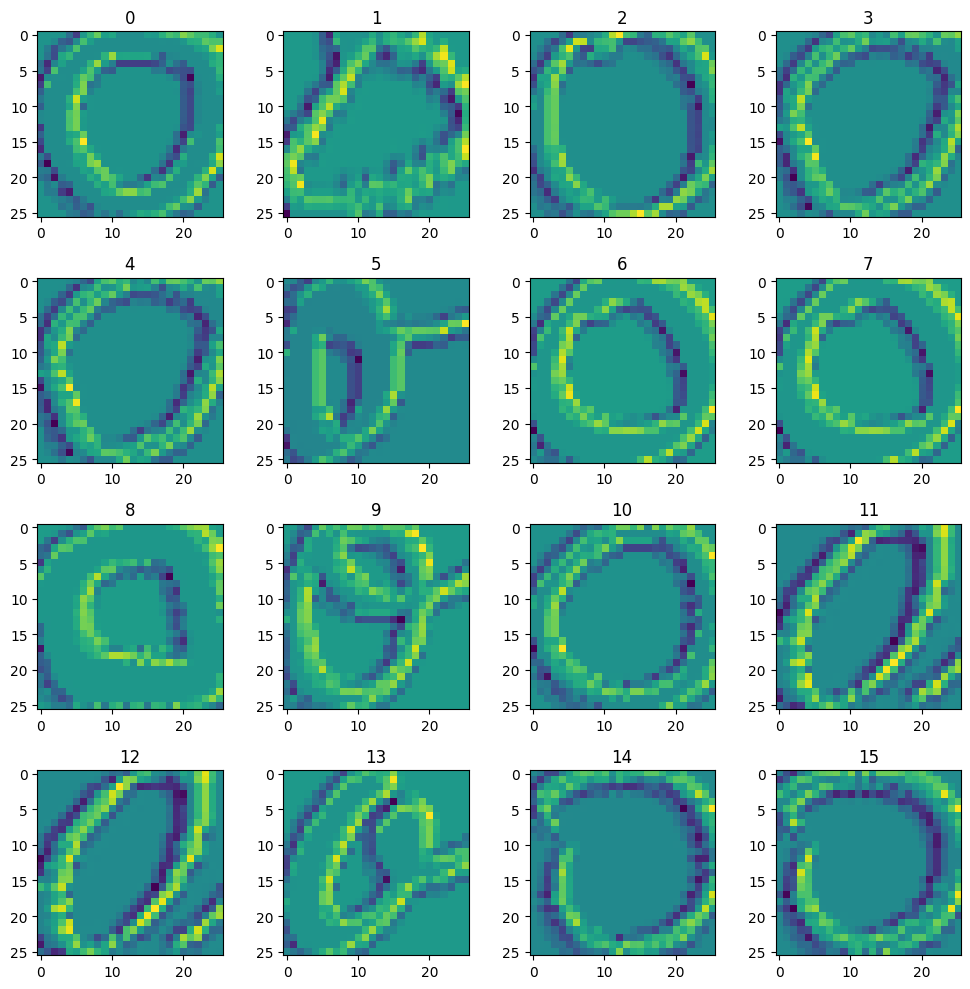

In [169]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [170]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

In [171]:
second_intermediate_output.shape

torch.Size([32, 128, 11, 11])

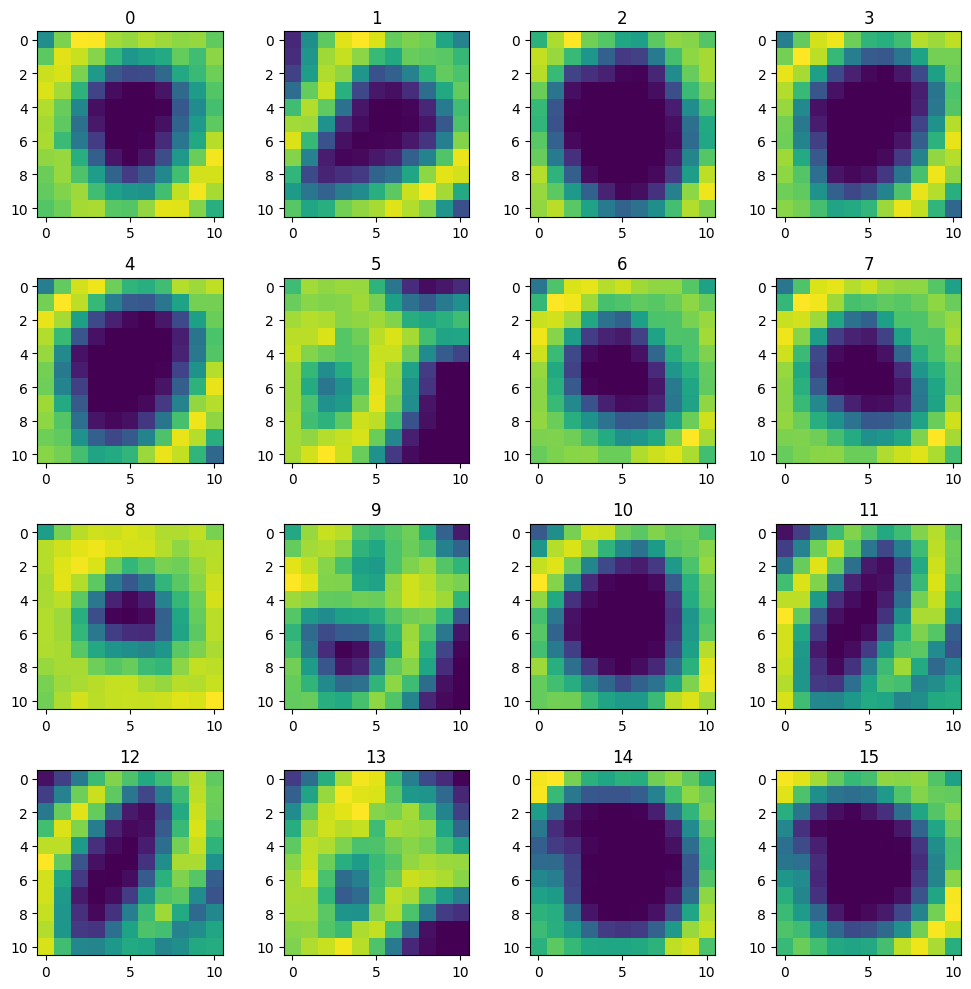

In [172]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [173]:
len(data)

2498

In [174]:
custom_dl = DataLoader(data, batch_size=2498, drop_last=True)

In [175]:
x, y = next(iter(custom_dl))

In [178]:
x.shape

torch.Size([2498, 1, 28, 28])

In [182]:
print(y)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [179]:
x2 = x[y==0]

In [180]:
len(x2)

2498

In [183]:
x2 = x2.view(len(x2),1,28,28)

In [184]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

In [185]:
flatten_layer_output.shape

torch.Size([2498, 3200])

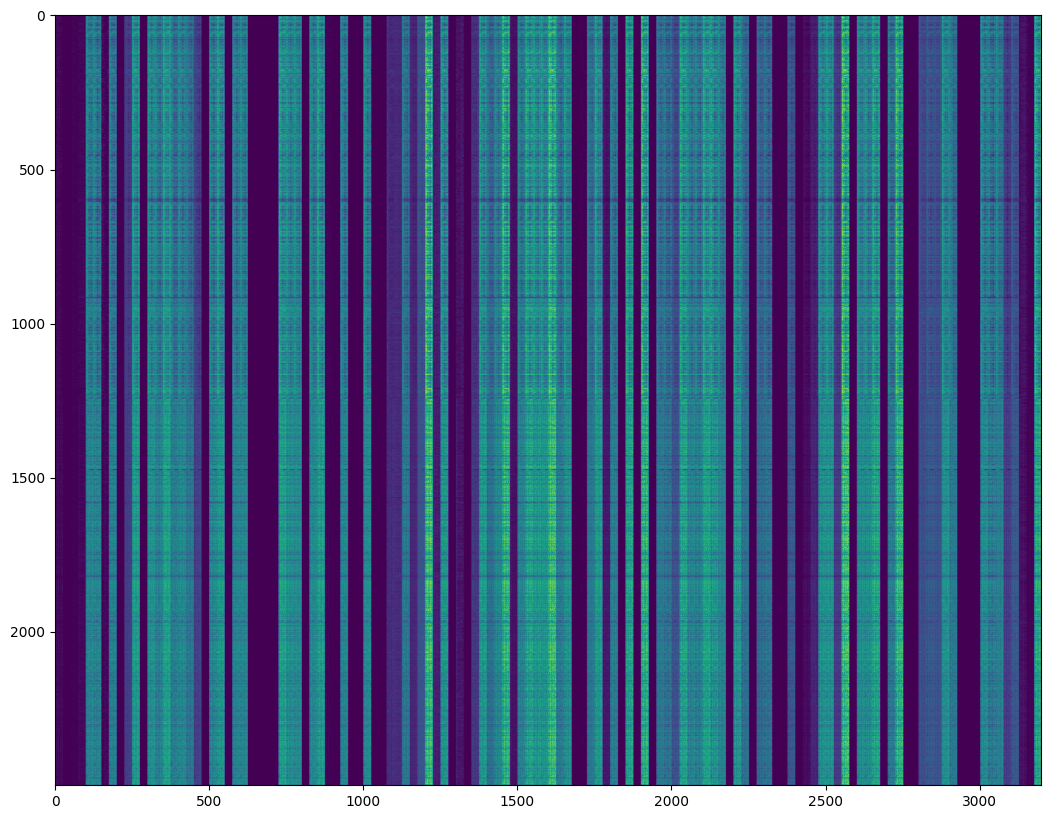

In [186]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())